In [1]:
paquetes <- c("bkmr", "dplyr", "ggplot2", "future", "readxl")

# Instalar aquellos paquetes que no estén instalados
nuevos_paquetes <- paquetes[!(paquetes %in% installed.packages()[, "Package"])]
if(length(nuevos_paquetes)) install.packages(nuevos_paquetes)
library(bkmr)
library(dplyr) #Charged for easier data manipulation. Part of the tidyverse.
library(ggplot2) #To make graphics
library(future) #For parallelization

library(readxl)
library(dplyr)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘zoo’, ‘dotCall64’, ‘sandwich’, ‘spam’, ‘maps’, ‘mvtnorm’, ‘gmm’, ‘fields’, ‘truncnorm’, ‘tmvtnorm’, ‘globals’, ‘listenv’, ‘parallelly’


For guided examples, go to 'https://jenfb.github.io/bkmr/overview.html'


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# Leer el archivo Excel desde la ruta montada
datos <- read_excel("datos_limpios_2.xlsx")

# Recodificar las variables ya que BKMR solo funciona con variables numericas
dataset <- datos %>%
  mutate(
    femb = ifelse(femb == "Sí", 1, ifelse(femb == "No", 0, NA)),
    preterm = ifelse(preterm == "sí", 1, ifelse(preterm == "no", 0, NA)),
    alcohol = ifelse(alcohol == "Si", 1, ifelse(alcohol == "No", 0, NA)),
    CSMIX3 = case_when(
      CSMIX3 == "CS I+II" ~ 1,
      CSMIX3 == "CS III"  ~ 2,
      CSMIX3 == "CS IV+V" ~ 3,
      TRUE               ~ NA_real_
    ),
    tipozonaM = case_when(
      tipozonaM == "Rural"     ~ 1,
      tipozonaM == "Semiurbana" ~ 2,
      tipozonaM == "Urbana"     ~ 3,
      TRUE                   ~ NA_real_
    )
  )

# Visualizar el dataset
print(dataset)


# A tibble: 1,147 × 20
   idnum  femb preterm sexo  madre_menarquia CSMIX3 imcm2 paridad tipozonaM
   <dbl> <dbl>   <dbl> <chr>           <dbl>  <dbl> <dbl>   <dbl>     <dbl>
 1     1     1       0 niña               14      2  18.1       0         2
 2     2     0       0 niña               14      1  19.9       0         3
 3     3     1       0 niña               12      3  19.4       0         3
 4     4     0       0 niña               11      3  32.8       1         3
 5     5     0       0 niña               13      2  24.5       2         2
 6     6     0       0 niña               13      1  19.7       1         3
 7     7     1       0 niña               13      2  21.5       0         3
 8     8     0       0 niña               13      1  24.3       1         3
 9     9     0       0 niña               11      2  21.8       0         3
10    10     0       0 niña               14      3  19.7       1         3
# ℹ 1,137 more rows
# ℹ 11 more variables: alcohol <dbl>, pfhxs <

In [3]:
# Variable de resultado
y <- dataset$edad_menarquia

# Variables de exposición: pasamos estas 9 columnas a una matriz Z
Z <- as.matrix(dataset[, c("pfhxs", "pfoa", "pfos", "pfna",
                           "v_44DDT", "v_44DDE", "HCB", "bHCH", "PCB")])

# Covariables de ajuste (ejemplo: femb, preterm, imcm2, etc.)
X <- as.matrix(dataset[, c("femb", "preterm", "imcm2", "paridad")])
# Ajusta la selección de covariables según tu hipótesis o necesidades analíticas


In [4]:
if(!"coda" %in% installed.packages()[, "Package"]){
  install.packages("coda")
}
library(coda)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [5]:
#En esta parte del codigo lo que hacemos es comparar el número de iteraciones dentro de nuestro BKMR para determinar cual es el mejor número de estos en base al ratio de coste/resultado
#Es decir, el coste aumenta casi de manera constante con las iteraciones, pero a medida que van aumentando las iteraciones el cambio de resultado va siendo distinto.
#Por tanto, cogeremos aquel que tenga el mejor resultado y un coste considerablemente bueno basandonos ne nuestro criterio propio

iter_list <- c(2000, 4000, 6000, 8000, 10000)
burnin_prop <- 0.25  # Se descarta el 25% de las iteraciones como burn-in

# Data frame para almacenar los resultados de ESS
ess_results <- data.frame(Iteration = numeric(), min_ESS = numeric())

# Bucle para ajustar el modelo para cada número de iteraciones y calcular el ESS mínimo
for (n_iter in iter_list) {
  set.seed(1234)  # Asegura la reproducibilidad
  cat("Corriendo modelo con", n_iter, "iteraciones...\n")

  # Ajusta el modelo BKMR
  fit_i <- kmbayes(
    y = y,
    Z = Z,
    X = X,
    iter = n_iter,
    varsel = TRUE,
    verbose = TRUE
  )

  # Calcular el burn-in y extraer la parte posterior
  burnin <- floor(n_iter * burnin_prop)
  beta_chain <- fit_i$beta[(burnin + 1):n_iter, , drop = FALSE]

  # Convertir a objeto MCMC y calcular el ESS de los coeficientes beta
  mcmc_beta <- mcmc(beta_chain)
  ess <- effectiveSize(mcmc_beta)
  min_ess <- min(ess)

  # Almacenar y mostrar los resultados
  ess_results <- rbind(ess_results, data.frame(Iteration = n_iter, min_ESS = min_ess))
  cat("Iteraciones =", n_iter, "; Minimum ESS =", min_ess, "\n\n")
}

# Mostrar la tabla final con los resultados
print(ess_results)

Corriendo modelo con 2000 iteraciones...



Iteration: 200 (10% completed; 1.10151 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.4974874
2 r/delta (overall) 0.3366834
3 r/delta  (move 1) 0.2952381
4 r/delta  (move 2) 0.3829787



Iteration: 400 (20% completed; 2.22745 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.5563910
2 r/delta (overall) 0.2631579
3 r/delta  (move 1) 0.2700000
4 r/delta  (move 2) 0.2562814



Iteration: 600 (30% completed; 3.33227 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6060100
2 r/delta (overall) 0.2303840
3 r/delta  (move 1) 0.2714777
4 r/delta  (move 2) 0.1915584



Iteration: 800 (40% completed; 4.43501 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6408010
2 r/delta (overall) 0.2302879
3 r/delta  (move 1) 0.2525773
4 r/delta  (move 2) 0.2092457



Iteration: 1000 (50% completed; 5.56213 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6746747
2 r/delta (overall) 0.2412412
3 r/delta  (move 1) 0.2269939
4 r/delta  (move 2) 0.2549020



Iteration: 1200 (60% completed; 6.67954 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6880734
2 r/delta (overall) 0.2468724
3 r/delta  (move 1) 0.2078365
4 r/delta  (move 2) 0.2843137



Iteration: 1400 (70% completed; 7.78211 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6897784
2 r/delta (overall) 0.2566119
3 r/delta  (move 1) 0.2088235
4 r/delta  (move 2) 0.3018081



Iteration: 1600 (80% completed; 8.89828 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6916823
2 r/delta (overall) 0.2632896
3 r/delta  (move 1) 0.2040816
4 r/delta  (move 2) 0.3202454



Iteration: 1800 (90% completed; 10.01825 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6970539
2 r/delta (overall) 0.2595887
3 r/delta  (move 1) 0.1988764
4 r/delta  (move 2) 0.3190319



Iteration: 2000 (100% completed; 11.12643 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.7003502
2 r/delta (overall) 0.2636318
3 r/delta  (move 1) 0.1985816
4 r/delta  (move 2) 0.3270751
Iteraciones = 2000 ; Minimum ESS = 58.85477 

Corriendo modelo con 4000 iteraciones...



Iteration: 400 (10% completed; 2.20742 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.5563910
2 r/delta (overall) 0.2631579
3 r/delta  (move 1) 0.2700000
4 r/delta  (move 2) 0.2562814



Iteration: 800 (20% completed; 4.36976 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6408010
2 r/delta (overall) 0.2302879
3 r/delta  (move 1) 0.2525773
4 r/delta  (move 2) 0.2092457



Iteration: 1200 (30% completed; 6.56337 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6880734
2 r/delta (overall) 0.2468724
3 r/delta  (move 1) 0.2078365
4 r/delta  (move 2) 0.2843137



Iteration: 1600 (40% completed; 8.71082 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6916823
2 r/delta (overall) 0.2632896
3 r/delta  (move 1) 0.2040816
4 r/delta  (move 2) 0.3202454



Iteration: 2000 (50% completed; 10.97767 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.7003502
2 r/delta (overall) 0.2636318
3 r/delta  (move 1) 0.1985816
4 r/delta  (move 2) 0.3270751



Iteration: 2400 (60% completed; 13.14535 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6902876
2 r/delta (overall) 0.2613589
3 r/delta  (move 1) 0.1941176
4 r/delta  (move 2) 0.3275434



Iteration: 2800 (70% completed; 15.32131 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6873884
2 r/delta (overall) 0.2575920
3 r/delta  (move 1) 0.1852118
4 r/delta  (move 2) 0.3293030



Iteration: 3200 (80% completed; 17.50695 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6811504
2 r/delta (overall) 0.2572679
3 r/delta  (move 1) 0.1877370
4 r/delta  (move 2) 0.3252938



Iteration: 3600 (90% completed; 19.70848 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6801889
2 r/delta (overall) 0.2550709
3 r/delta  (move 1) 0.1804299
4 r/delta  (move 2) 0.3271436



Iteration: 4000 (100% completed; 21.91979 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6801700
2 r/delta (overall) 0.2535634
3 r/delta  (move 1) 0.1712398
4 r/delta  (move 2) 0.3333333
Iteraciones = 4000 ; Minimum ESS = 138.4703 

Corriendo modelo con 6000 iteraciones...



Iteration: 600 (10% completed; 2.97696 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6060100
2 r/delta (overall) 0.2303840
3 r/delta  (move 1) 0.2714777
4 r/delta  (move 2) 0.1915584



Iteration: 1200 (20% completed; 5.94839 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6880734
2 r/delta (overall) 0.2468724
3 r/delta  (move 1) 0.2078365
4 r/delta  (move 2) 0.2843137



Iteration: 1800 (30% completed; 8.89319 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6970539
2 r/delta (overall) 0.2595887
3 r/delta  (move 1) 0.1988764
4 r/delta  (move 2) 0.3190319



Iteration: 2400 (40% completed; 11.86387 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6902876
2 r/delta (overall) 0.2613589
3 r/delta  (move 1) 0.1941176
4 r/delta  (move 2) 0.3275434



Iteration: 3000 (50% completed; 14.8263 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6838946
2 r/delta (overall) 0.2594198
3 r/delta  (move 1) 0.1898055
4 r/delta  (move 2) 0.3282493



Iteration: 3600 (60% completed; 17.78028 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6801889
2 r/delta (overall) 0.2550709
3 r/delta  (move 1) 0.1804299
4 r/delta  (move 2) 0.3271436



Iteration: 4200 (70% completed; 20.73467 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6804001
2 r/delta (overall) 0.2479162
3 r/delta  (move 1) 0.1656205
4 r/delta  (move 2) 0.3280075



Iteration: 4800 (80% completed; 23.67989 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6732653
2 r/delta (overall) 0.2431757
3 r/delta  (move 1) 0.1567886
4 r/delta  (move 2) 0.3280992



Iteration: 5400 (90% completed; 26.6474 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6712354
2 r/delta (overall) 0.2411558
3 r/delta  (move 1) 0.1468165
4 r/delta  (move 2) 0.3334555



Iteration: 6000 (100% completed; 29.5943 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6707785
2 r/delta (overall) 0.2462077
3 r/delta  (move 1) 0.1480860
4 r/delta  (move 2) 0.3429328
Iteraciones = 6000 ; Minimum ESS = 473.8136 

Corriendo modelo con 8000 iteraciones...



Iteration: 800 (10% completed; 3.94388 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6408010
2 r/delta (overall) 0.2302879
3 r/delta  (move 1) 0.2525773
4 r/delta  (move 2) 0.2092457



Iteration: 1600 (20% completed; 7.88316 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6916823
2 r/delta (overall) 0.2632896
3 r/delta  (move 1) 0.2040816
4 r/delta  (move 2) 0.3202454



Iteration: 2400 (30% completed; 11.79552 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6902876
2 r/delta (overall) 0.2613589
3 r/delta  (move 1) 0.1941176
4 r/delta  (move 2) 0.3275434



Iteration: 3200 (40% completed; 15.70656 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6811504
2 r/delta (overall) 0.2572679
3 r/delta  (move 1) 0.1877370
4 r/delta  (move 2) 0.3252938



Iteration: 4000 (50% completed; 19.62844 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6801700
2 r/delta (overall) 0.2535634
3 r/delta  (move 1) 0.1712398
4 r/delta  (move 2) 0.3333333



Iteration: 4800 (60% completed; 23.52866 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6732653
2 r/delta (overall) 0.2431757
3 r/delta  (move 1) 0.1567886
4 r/delta  (move 2) 0.3280992



Iteration: 5600 (70% completed; 27.45759 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6710127
2 r/delta (overall) 0.2427219
3 r/delta  (move 1) 0.1501263
4 r/delta  (move 2) 0.3334512



Iteration: 6400 (80% completed; 31.36961 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6735427
2 r/delta (overall) 0.2469136
3 r/delta  (move 1) 0.1460497
4 r/delta  (move 2) 0.3463687



Iteration: 7200 (90% completed; 35.29027 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6753716
2 r/delta (overall) 0.2421170
3 r/delta  (move 1) 0.1400670
4 r/delta  (move 2) 0.3432918



Iteration: 8000 (100% completed; 39.22304 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6717090
2 r/delta (overall) 0.2437805
3 r/delta  (move 1) 0.1421053
4 r/delta  (move 2) 0.3449738
Iteraciones = 8000 ; Minimum ESS = 764.6809 

Corriendo modelo con 10000 iteraciones...



Iteration: 1000 (10% completed; 5.07523 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6746747
2 r/delta (overall) 0.2412412
3 r/delta  (move 1) 0.2269939
4 r/delta  (move 2) 0.2549020



Iteration: 2000 (20% completed; 10.15533 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.7003502
2 r/delta (overall) 0.2636318
3 r/delta  (move 1) 0.1985816
4 r/delta  (move 2) 0.3270751



Iteration: 3000 (30% completed; 15.2216 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6838946
2 r/delta (overall) 0.2594198
3 r/delta  (move 1) 0.1898055
4 r/delta  (move 2) 0.3282493



Iteration: 4000 (40% completed; 20.27992 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6801700
2 r/delta (overall) 0.2535634
3 r/delta  (move 1) 0.1712398
4 r/delta  (move 2) 0.3333333



Iteration: 5000 (50% completed; 25.32988 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6737347
2 r/delta (overall) 0.2430486
3 r/delta  (move 1) 0.1534434
4 r/delta  (move 2) 0.3314785



Iteration: 6000 (60% completed; 30.39294 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6707785
2 r/delta (overall) 0.2462077
3 r/delta  (move 1) 0.1480860
4 r/delta  (move 2) 0.3429328



Iteration: 7000 (70% completed; 35.42332 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6753822
2 r/delta (overall) 0.2426061
3 r/delta  (move 1) 0.1405219
4 r/delta  (move 2) 0.3439636



Iteration: 8000 (80% completed; 40.44977 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6717090
2 r/delta (overall) 0.2437805
3 r/delta  (move 1) 0.1421053
4 r/delta  (move 2) 0.3449738



Iteration: 9000 (90% completed; 45.48164 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6744083
2 r/delta (overall) 0.2461385
3 r/delta  (move 1) 0.1430170
4 r/delta  (move 2) 0.3478261



Iteration: 10000 (100% completed; 50.52012 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6736674
2 r/delta (overall) 0.2440244
3 r/delta  (move 1) 0.1419082
4 r/delta  (move 2) 0.3448619
Iteraciones = 10000 ; Minimum ESS = 1196.969 

  Iteration    min_ESS
1      2000   58.85477
2      4000  138.47026
3      6000  473.81356
4      8000  764.68088
5     10000 1196.96930


In [6]:
#Realizamos el modelo bkmr con el número de iteraciones determinado en el chunck de arriba.
fit_bkmr <- kmbayes(
  y = y,
  Z = Z,
  X = X,
  iter = 6000,       # Número de iteraciones MCMC (modifica según convergencia)
  varsel = TRUE,
  verbose = TRUE     # Muestra el progreso en pantalla
)

Iteration: 600 (10% completed; 2.97066 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6460768
2 r/delta (overall) 0.2537563
3 r/delta  (move 1) 0.2870662
4 r/delta  (move 2) 0.2163121



Iteration: 1200 (20% completed; 5.93798 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6480400
2 r/delta (overall) 0.2477064
3 r/delta  (move 1) 0.3019481
4 r/delta  (move 2) 0.1903945



Iteration: 1800 (30% completed; 8.92965 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6698166
2 r/delta (overall) 0.2468038
3 r/delta  (move 1) 0.2693966
4 r/delta  (move 2) 0.2227325



Iteration: 2400 (40% completed; 11.92073 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6677782
2 r/delta (overall) 0.2459358
3 r/delta  (move 1) 0.2688525
4 r/delta  (move 2) 0.2222222



Iteration: 3000 (50% completed; 14.87352 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6668890
2 r/delta (overall) 0.2507503
3 r/delta  (move 1) 0.2473684
4 r/delta  (move 2) 0.2542258



Iteration: 3600 (60% completed; 17.86852 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6726869
2 r/delta (overall) 0.2531259
3 r/delta  (move 1) 0.2320351
4 r/delta  (move 2) 0.2747748



Iteration: 4200 (70% completed; 20.8346 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6763515
2 r/delta (overall) 0.2541081
3 r/delta  (move 1) 0.2198781
4 r/delta  (move 2) 0.2894482



Iteration: 4800 (80% completed; 23.82438 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6818087
2 r/delta (overall) 0.2531777
3 r/delta  (move 1) 0.2039984
4 r/delta  (move 2) 0.3045145



Iteration: 5400 (90% completed; 26.7829 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6816077
2 r/delta (overall) 0.2548620
3 r/delta  (move 1) 0.1977463
4 r/delta  (move 2) 0.3141994



Iteration: 6000 (100% completed; 29.7217 mins elapsed)



Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6812802
2 r/delta (overall) 0.2497083
3 r/delta  (move 1) 0.1890564
4 r/delta  (move 2) 0.3125212


In [7]:
# Resumen rápido
summary(fit_bkmr)

Fitted object of class 'bkmrfit'
Iterations: 6000 
Outcome family: gaussian  
Model fit on: 2025-04-15 18:13:49.623683 
Running time:  29.72186 mins 

Acceptance rates for Metropolis-Hastings algorithm:
              param      rate
1            lambda 0.6812802
2 r/delta (overall) 0.2497083
3 r/delta  (move 1) 0.1890564
4 r/delta  (move 2) 0.3125212

Parameter estimates (based on iterations 3001-6000):
       param     mean       sd    q_2.5   q_97.5
1      beta1 -0.12771  0.07426 -0.27113  0.01920
2      beta2  1.10419  0.28845  0.52955  1.66340
3      beta3 -0.06148  0.00890 -0.07848 -0.04350
4      beta4  0.14109  0.05943  0.02504  0.25763
5  sigsq.eps  1.26641  0.05636  1.16100  1.37817
6         r1  0.10391  0.05662  0.01848  0.23927
7         r2  0.00000  0.00020  0.00000  0.00000
8         r3  0.01174  0.00217  0.01035  0.01877
9         r4  0.02518  0.01677  0.00000  0.05902
10        r5  0.01180  0.02078  0.00000  0.05147
11        r6  0.00000  0.00000  0.00000  0.00000
12   

NULL

In [8]:
ExtractPIPs(fit_bkmr)
#Sacamos los PIPs que son el porcentaje de relevancia de las variables para explicar las variables explicada.

variable,PIP
<chr>,<dbl>
pfhxs,1.0000000000
pfoa,0.0003333333
pfos,1.0000000000
pfna,0.9033333333
v_44DDT,0.5163333333
v_44DDE,0.0000000000
HCB,1.0000000000
bHCH,1.0000000000
PCB,0.0926666667


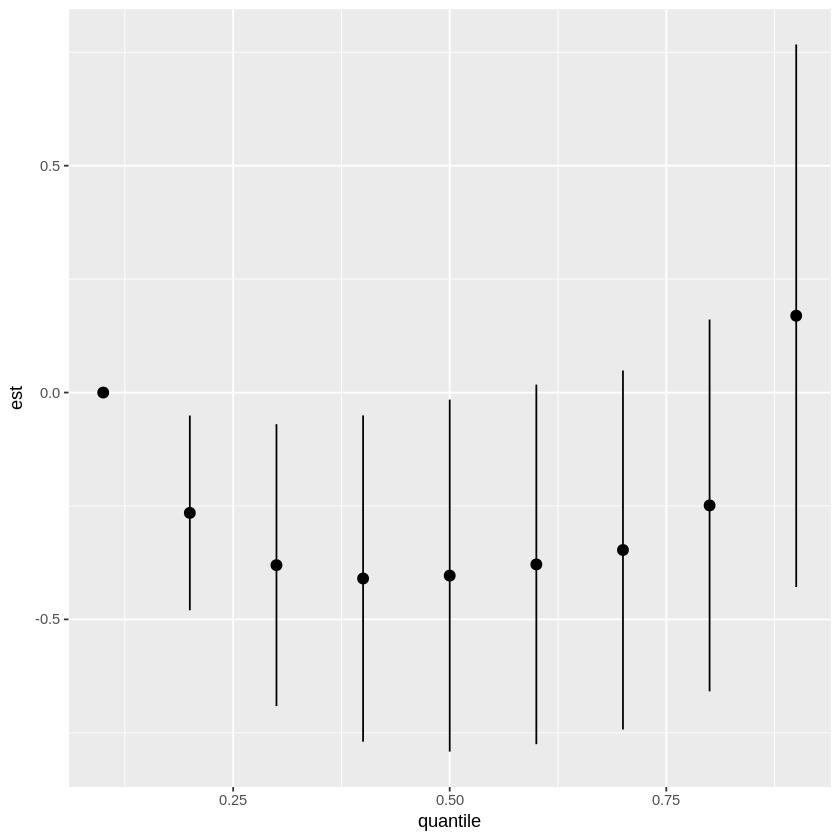

In [9]:
risks.overall <- OverallRiskSummaries(fit = fit_bkmr, y = fit_bkmr$y, Z = fit_bkmr$Z, X = fit_bkmr$X,
                                      qs = seq(0.1, 0.9, by = 0.10), #The percentile to display
                                      q.fixed = 0.1, method = "exact") #exact is more precise but slower than "approx"

ggplot(risks.overall, aes(quantile, est, ymin = est - 1.96*sd, ymax = est + 1.96*sd)) +
    geom_pointrange()

#Es una forma intuitiva de visualizar el efecto conjunto de la mezcla sobre el resultado, con sus respectivos intervalos de credibilidad.

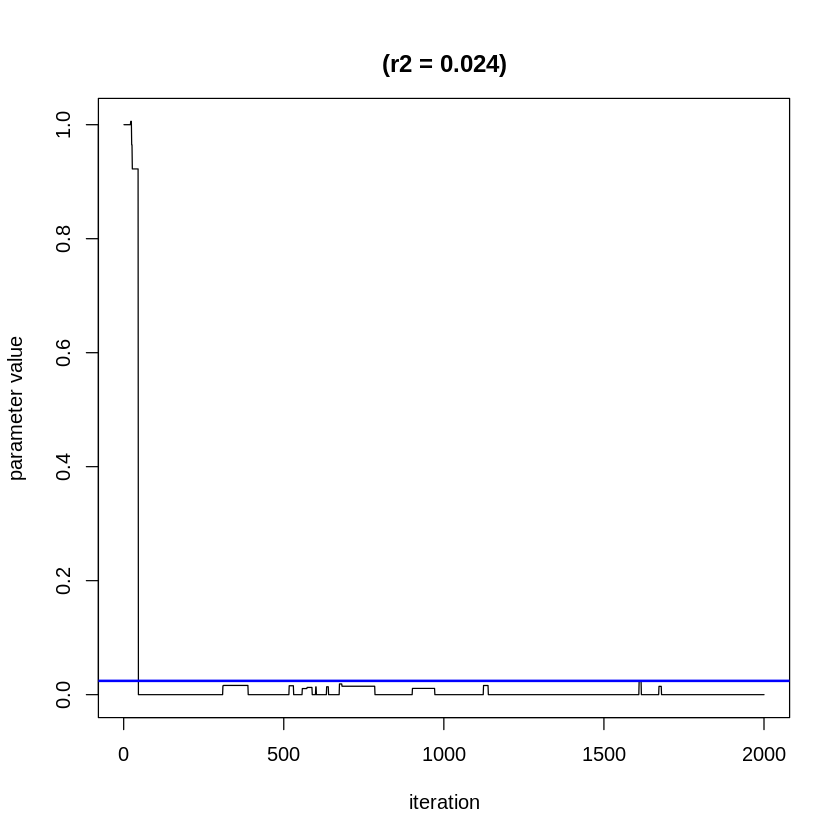

In [10]:
TracePlot(fit_bkmr, par="r",comp=2,sel=1:2000)
#este traceplot te ayuda a asegurarte de que tu R² posterior está bien estimado (convergencia)
#te da una medida interpretable del “peso” global de tu mezcla de contaminantes sobre el resultado de interés.


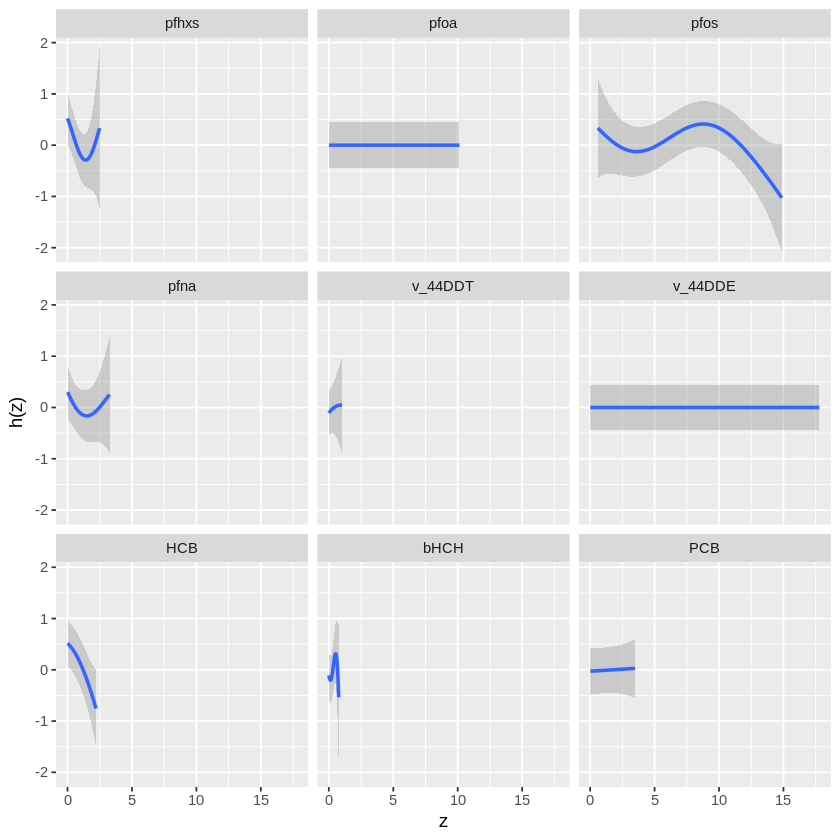

In [11]:
pred.resp.univar <- PredictorResponseUnivar(fit = fit_bkmr,method="exact") # exact method give unbiaised results but is longer to run

#Creating the graph
ggplot(pred.resp.univar, aes(z, est, ymin = est - 1.96*se, ymax = est + 1.96*se)) +
    geom_smooth(stat = "identity") +
    facet_wrap(~ variable) +
  ylab("h(z)")

#Observamos la distribucion que sigue cada variable explicativa para explicar la variable explicada